In [1]:
#importing relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import statsmodels.api as sm
import pandasql as ps
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score



In [2]:
#reading scraped data into a dataframe
df=pd.read_csv('Data/teams.csv')

In [3]:
df.head(3)

,Unnamed: 0,shirtnumber,position,age,minutes,goals,assists,pens_made,pens_att,shots_total,...,offsides,pens_won,pens_conceded,own_goals,ball_recoveries,aerials_won,aerials_lost,aerials_won_pct,Venue,TeamName
0,0,10,FW,30,90.0,1,0,0,0,3,...,1,0.0,0.0,0,5.0,1.0,0.0,100.0,Home,Liverpool
1,1,23,LW,25,90.0,0,0,0,0,3,...,0,0.0,0.0,0,9.0,1.0,0.0,100.0,Home,Liverpool
2,2,20,RW,25,57.0,0,0,0,0,3,...,0,0.0,0.0,0,7.0,0.0,1.0,0.0,Home,Liverpool


# Data Manipulation

In [4]:
#divide given positions to 4 positions FPL considers
for index,row in df.iterrows():
    if row['position'] in ['FW']:
        df.at[index,'fpl_position'] = 'Forward'
    elif row['position'] in ['LW','RW','CM','AM','DM','LM','RM']:
        df.at[index,'fpl_position'] = 'Midfielder'
    elif row['position'] in ['LB','RB','CB','WB','DF']:
        df.at[index,'fpl_position'] = 'Defender'
    elif row['position'] in ['GK']:
        df.at[index,'fpl_position'] = 'GoalKeeper'        

In [5]:
#calculate fpl points using available stats
#This is not the way FPL currently calculates fpl points. I will be using this as an approximation for the time being
df['fpl_points'] = 1+ 4*df['goals']+3*df['assists']+1*(df['minutes']>=60.0)-1*df['cards_yellow']\
            -2*df['own_goals']-2*(df['pens_att']-df['pens_made'])

In [6]:
df['rank'] = df.groupby(by = ['name'])['Unnamed: 0'].rank(ascending=False)
df.head(3)

,Unnamed: 0,shirtnumber,position,age,minutes,goals,assists,pens_made,pens_att,shots_total,...,own_goals,ball_recoveries,aerials_won,aerials_lost,aerials_won_pct,Venue,TeamName,fpl_position,fpl_points,rank
0,0,10,FW,30,90.0,1,0,0,0,3,...,0,5.0,1.0,0.0,100.0,Home,Liverpool,Forward,6,34.0
1,1,23,LW,25,90.0,0,0,0,0,3,...,0,9.0,1.0,0.0,100.0,Home,Liverpool,Midfielder,2,13.0
2,2,20,RW,25,57.0,0,0,0,0,3,...,0,7.0,0.0,1.0,0.0,Home,Liverpool,Midfielder,1,35.0


In [7]:
#create new dataframe with relevant columns to be used for modelling
df_model = df[['name','fpl_position','age','shots_total','shots_on_target','touches','pressures','tackles','interceptions',
  'blocks','xg','npxg','xa','sca','gca','passes_completed','passes','progressive_passes','carries',
  'progressive_carries','dribbles_completed','dribbles','Venue','fpl_points','rank']]

In [8]:
#exclude goalkeepers for modelling
df_model_nogk = df_model.loc[df_model['fpl_position'] != 'GoalKeeper']
df_model_nogk.shape

(9723, 25)

# EDA

In [9]:
#remove null values. There is only one row for this dataset having null values
df_model_nogk = df_model_nogk.dropna()
df_model_nogk.describe()

,age,shots_total,shots_on_target,touches,pressures,tackles,interceptions,blocks,xg,npxg,...,gca,passes_completed,passes,progressive_passes,carries,progressive_carries,dribbles_completed,dribbles,fpl_points,rank
count,9722.000000,9722.000000,9722.000000,9722.000000,9722.000000,9722.000000,9722.000000,9722.000000,9722.000000,9722.000000,...,9722.000000,9722.000000,9722.000000,9722.000000,9722.000000,9722.000000,9722.000000,9722.000000,9722.000000,9722.000000
mean,26.298190,0.995783,0.324933,44.541247,11.487965,1.387677,1.182370,1.225262,0.106521,0.098457,...,0.169924,28.533532,35.523966,2.424501,28.320202,3.262189,0.657992,1.218576,2.253754,13.556676
std,3.852765,1.304043,0.645985,26.152410,7.708472,1.518593,1.400459,1.354494,0.219412,0.197411,...,0.455993,21.497572,24.097270,2.468463,18.932971,3.338477,1.065967,1.652900,1.808920,8.926884
min,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,1.000000
25%,23.000000,0.000000,0.000000,25.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,12.000000,17.000000,1.000000,14.000000,1.000000,0.000000,0.000000,1.000000,6.000000
50%,26.000000,1.000000,0.000000,43.000000,10.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,24.000000,32.000000,2.000000,26.000000,2.000000,0.000000,1.000000,2.000000,12.000000
75%,29.000000,2.000000,0.000000,61.000000,16.000000,2.000000,2.000000,2.000000,0.100000,0.100000,...,0.000000,41.000000,50.000000,4.000000,39.000000,5.000000,1.000000,2.000000,2.000000,20.000000
max,37.000000,10.000000,5.000000,155.000000,55.000000,10.000000,10.000000,8.000000,2.500000,2.500000,...,5.000000,138.000000,143.000000,19.000000,126.000000,27.000000,14.000000,20.000000,21.000000,38.000000


Text(0.5, 1.0, 'Correlation Heatmap')

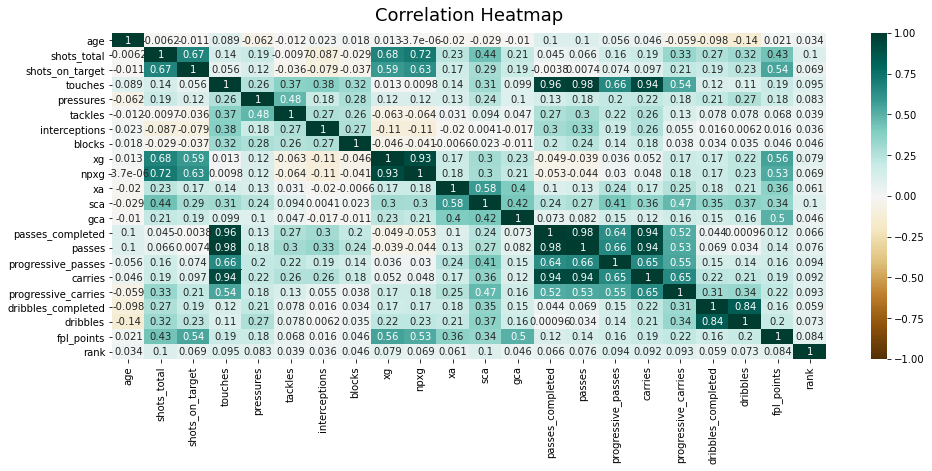

In [10]:
#plot correlation heatmap
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_model_nogk.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

Looking at the correlation heatmap, it is evident that touches,passes,carries and passes_completed are heavily correlated. Similarly, dribbles and driblles_completed are highly correlated.

In [11]:
#top 10 players by fpl points and their stats
df_eda = df[['name','goals','assists','xg','npxg','xa','fpl_points']].reset_index()
df_season_stats = df_eda.groupby('name').sum()
df_top10 = df_season_stats.sort_values(by = ['fpl_points'],ascending = False).head(10).reset_index()
df_top10

,name,index,goals,assists,xg,npxg,xa,fpl_points
0,Mohamed-Salah,178734,23,13,21.6,16.9,10.3,193
1,Son-Heung-min,194204,23,7,16.3,16.3,8.2,181
2,Harry-Kane,202933,17,9,20.1,17.0,8.9,163
3,Jarrod-Bowen,205440,12,10,11.5,11.5,5.8,141
4,Kevin-De-Bruyne,148333,15,8,6.3,6.3,9.3,135
5,Bukayo-Saka,194060,11,7,9.6,8.2,6.7,131
6,James-Maddison,191344,12,8,8.1,8.1,4.8,131
7,Sadio-Mane,168581,16,2,16.5,16.5,4.4,130
8,Cristiano-Ronaldo,122626,18,3,16.6,14.3,3.2,130
9,Diogo-Jota,185618,15,4,16.5,16.5,5.4,129


In [12]:
df_eda['rank'] = df_eda.groupby(by = ['name'])['index'].rank(ascending=False)
df_eda.head()

,index,name,goals,assists,xg,npxg,xa,fpl_points,rank
0,0,Sadio-Mane,1,0,0.5,0.5,0.2,6,34.0
1,1,Luis-Diaz,0,0,0.5,0.5,0.1,2,13.0
2,2,Diogo-Jota,0,0,0.5,0.5,0.0,1,35.0
3,3,Mohamed-Salah,1,0,0.9,0.9,0.1,5,35.0
4,4,Thiago-Alcantara,0,1,0.0,0.0,0.3,4,25.0


In [13]:
df_season_stats.reset_index().to_csv("player_level_season_stats.csv")

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Mohamed-Salah'),
  Text(1, 0, 'Son-Heung-min'),
  Text(2, 0, 'Harry-Kane'),
  Text(3, 0, 'Jarrod-Bowen'),
  Text(4, 0, 'Kevin-De-Bruyne'),
  Text(5, 0, 'Bukayo-Saka'),
  Text(6, 0, 'James-Maddison'),
  Text(7, 0, 'Sadio-Mane'),
  Text(8, 0, 'Cristiano-Ronaldo'),
  Text(9, 0, 'Diogo-Jota')])

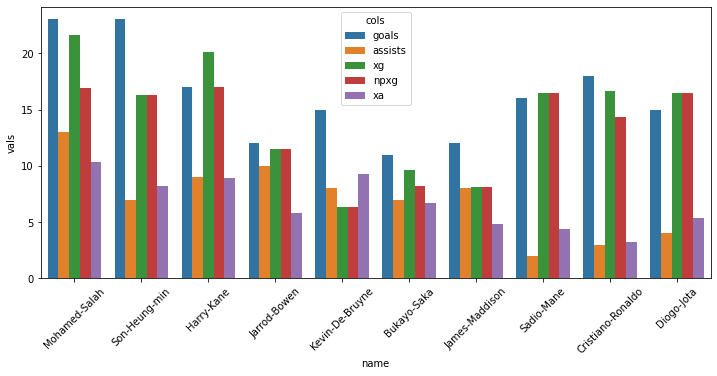

In [14]:
#melt df to creat barplot
dfm = df_top10[['name','goals','assists','xg','npxg','xa']].melt('name',var_name = "cols",value_name = "vals")
#plot stats fir the top10 players
plt.figure(figsize = (12,5))
g = sns.barplot(x = "name",y= "vals",hue = "cols",data = dfm)
plt.xticks(rotation = 45)

In [15]:
#create new dataframe with relevant columns to be used for modelling
query = """   Select name, 
avg(age) as age,
avg(shots_total) as shots_total,
avg(shots_on_target) as shots_on_target,
avg(touches) as touches,
avg(pressures) as pressures,
avg(tackles) as tackles,
avg(interceptions) as interceptions,
avg(passes) as passes,
avg(progressive_passes) as progressive_passes,
avg(blocks) as blocks,
avg(xg) as xg,
avg(npxg) as npxg,
avg(xa) as xa,
avg(sca) as sca,
avg(gca) as gca,
avg(passes_completed) as passes_completed,
avg(carries) as carries,
avg(progressive_carries) as progressive_carries,
avg(dribbles_completed) as dribbles_completed,
avg(dribbles) as dribbles,
avg(fpl_points) as fpl_points
from df_model_nogk
where rank <=5.0
group by 1
"""

df_last5_avg = ps.sqldf(query)
df_last5_avg.head(3)


,name,age,shots_total,shots_on_target,touches,pressures,tackles,interceptions,passes,progressive_passes,...,npxg,xa,sca,gca,passes_completed,carries,progressive_carries,dribbles_completed,dribbles,fpl_points
0,Aaron-Connolly,21.0,0.5,0.0,8.5,6.75,0.0,0.0,4.5,0.0,...,0.10,0.10,0.5,0.0,3.75,5.5,0.75,0.0,0.25,1.25
1,Aaron-Cresswell,31.6,0.6,0.2,80.6,7.60,1.2,1.2,72.2,5.0,...,0.02,0.06,1.0,0.0,57.40,52.0,4.20,0.0,0.40,2.60
2,Aaron-Lennon,34.6,1.0,0.2,15.0,9.80,0.8,0.8,8.4,0.6,...,0.06,0.00,1.0,0.0,5.80,8.8,1.20,0.4,0.80,1.40


In [16]:
df_last5_avg.to_csv('avg_stats_last5_gameweeks.csv')

# Modelling

##  1) Linear Regression

In [17]:
X = df_model_nogk.loc[:,~df_model_nogk.columns.isin(['fpl_position','fpl_points','Venue','rank','name'])]
y = df_model_nogk['fpl_points']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state = 1)


regressor = LinearRegression()
regressor.fit(X_train,y_train)


y_pred = regressor.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')

predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Regressor Score: ",regressor.score(X_test, y_test))

Mean absolute error: 0.80
Mean squared error: 1.42
Root mean squared error: 1.19
Accuracy: 51.00%
Regressor Score:  0.5510229537154107


In [18]:
X_constant = sm.add_constant(X)
lin_reg = sm.OLS(y,X_constant).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             fpl_points   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     651.9
Date:                Thu, 21 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:57:11   Log-Likelihood:                -15416.
No. Observations:                9722   AIC:                         3.087e+04
Df Residuals:                    9701   BIC:                         3.102e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.8033      0.089      9.076      0.000       0.630       0.977
age                     0.0062      0.003      1.922      0.055      -0.000       0.012
shots_total            -0.1980      0.016    -12.072      0.000      -0.230      -0.166
shots_on_target         0.9951      0.026     37.798      0.000       0.943       1.047
touches                 0.0305      0.004      7.147      0.000       0.022       0.039
pressures               0.0085      0.002      4.371      0.000       0.005       0.012
tackles                -0.0014      0.010     -0.138      0.891      -0.021       0.018
interceptions          -0.0018      0.010     -0.175      0.861      -0.022       0.018
blocks                 -0.0047      0.011     -0.420      0.674      -0.026       0.017
xg                      3.5278      0.147     23.935      0.000       3.239       3.817
npxg                   -0.7332      0.175     -4.201      0.000      -1.075      -0.391
xa                      2.1014      0.100     20.912      0.000       1.904       2.298
sca                    -0.1145      0.010    -11.031      0.000      -0.135      -0.094
gca                     1.3604      0.030     45.368      0.000       1.302       1.419
passes_completed       -0.0048      0.004     -1.327      0.185      -0.012       0.002
passes                 -0.0137      0.005     -2.499      0.012      -0.024      -0.003
progressive_passes     -0.0110      0.007     -1.567      0.117      -0.025       0.003
carries                -0.0053      0.003     -1.991      0.046      -0.011   -8.26e-05
progressive_carries     0.0058      0.005      1.080      0.280      -0.005       0.016
dribbles_completed     -0.0122      0.021     -0.570      0.569      -0.054       0.030
dribbles               -0.0006      0.015     -0.039      0.969      -0.031       0.029
==============================================================================
Omnibus:                     1468.234   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8059.201
Skew:                           0.613   Prob(JB):                         0.00
Kurtosis:                       7.289   Cond. No.                     1.59e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.59e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The linear regression model summary suggests that there is strong multicolinearity among some variables. We had noted this while visualising the correlation heatmap. Also, some of the coefficients are not significant at p-values of 0.01 (e.g tackles, interceptions, blocks, progressive_passes, etc.)

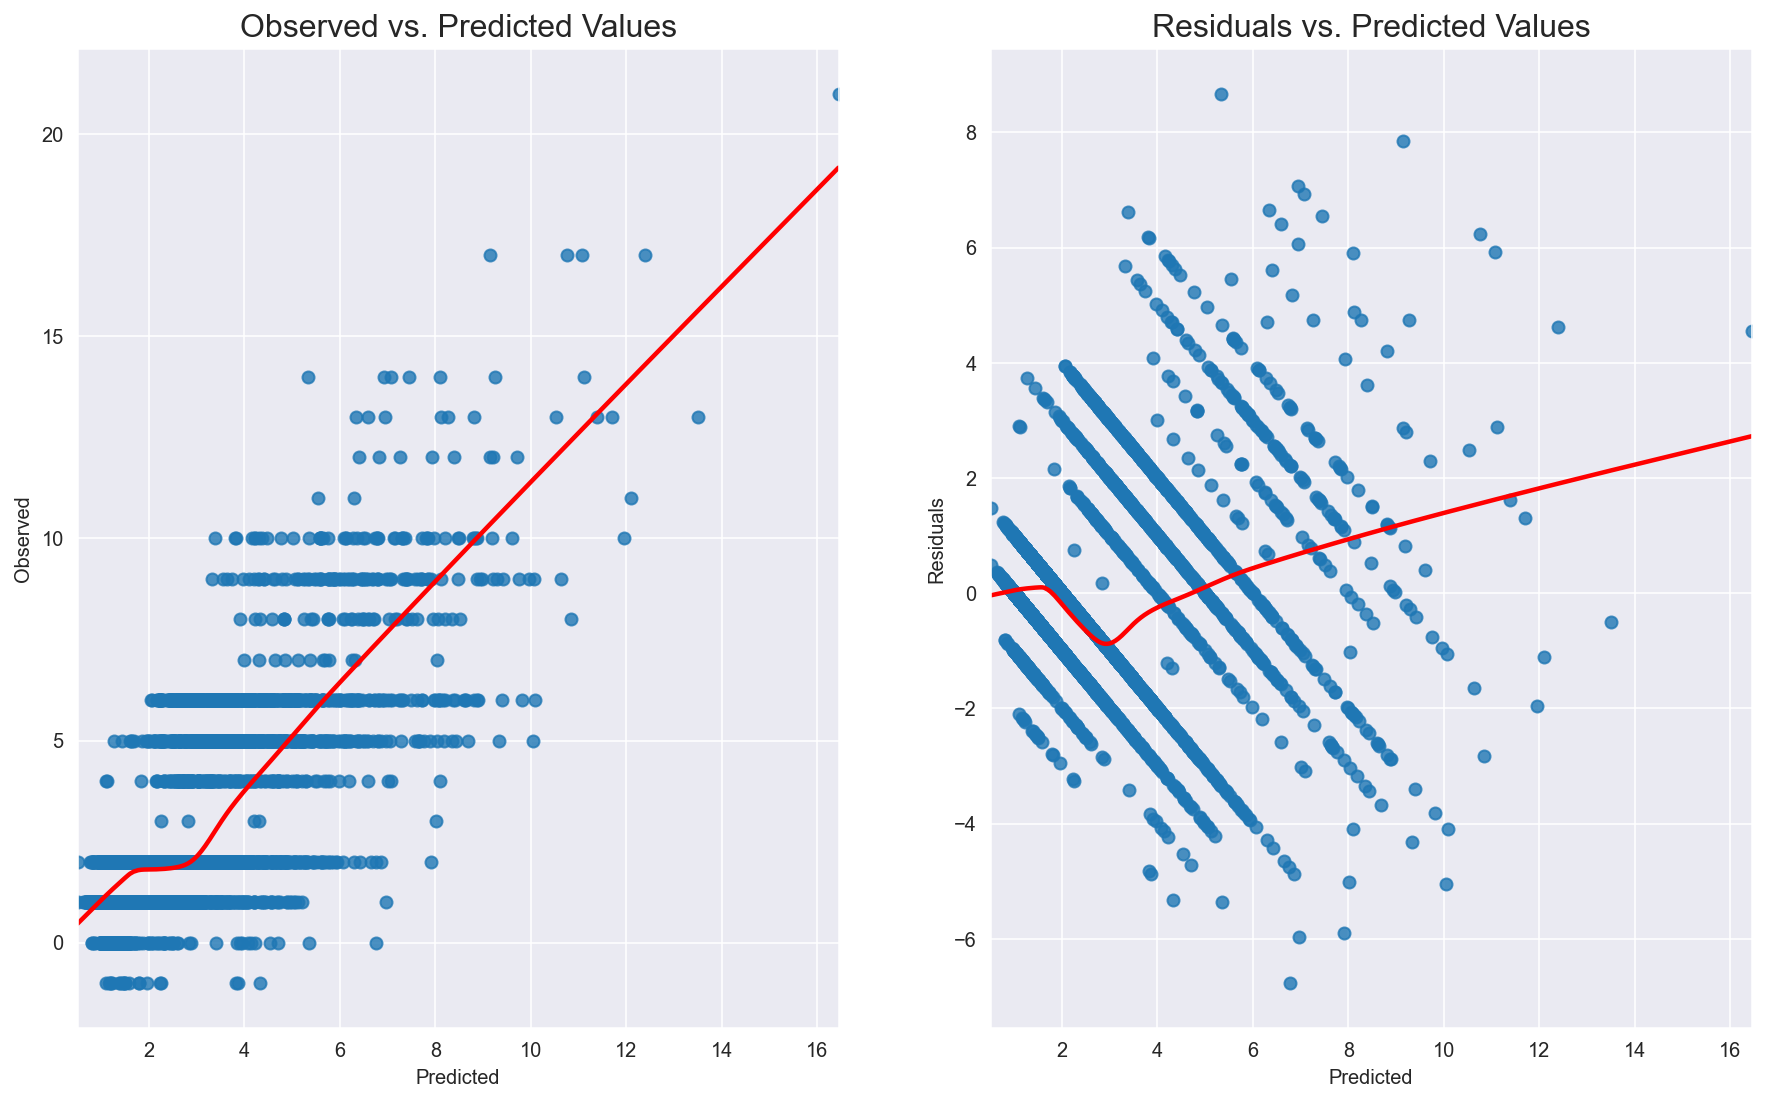

In [19]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2)
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')
    
linearity_test(lin_reg, y)    

The predicted vs residuals plots indicate that the constant variance assumption is violated. Also, there are clusters of residuals implying the independence assumption does not hold. The linearity assumption seems to be violated as well as the points don't seem to be symettrically distributed accross the diagnol.

In [20]:

vif = [variance_inflation_factor(X_constant.values, i) for i in range(X_constant.shape[1])]
pd.DataFrame({'vif': vif[1:]}, index=X.columns).T

,age,shots_total,shots_on_target,touches,pressures,tackles,interceptions,blocks,xg,npxg,xa,sca,gca,passes_completed,passes,progressive_passes,carries,progressive_carries,dribbles_completed,dribbles
vif,1.056507,3.179569,2.009846,86.464278,1.575834,1.649293,1.432968,1.564096,7.267633,8.248336,1.612255,2.297698,1.299113,42.374403,121.713502,2.104401,17.650619,2.27197,3.641843,4.449607


To check the multicollinearity, we use the variance inflation factor (vif). Passes, touches, passes_completed have high vif values. We remove them one by one and create new models. 

In [21]:
#create new X,y excluding coefficients with high vif. Removed the coefficients one by one, not all at once
X_new = df_model_nogk.loc[:,~df_model_nogk.columns.isin(['fpl_position','fpl_points','Venue','passes','passes_completed','touches','rank','name'])]
y_new = df_model_nogk['fpl_points']


In [22]:
X_prediction = df_last5_avg.loc[:,~df_last5_avg.columns.isin(['fpl_position','fpl_points','Venue','rank','name'])]
y_prediction = regressor.predict(X_prediction)
y_test_pred  = pd.DataFrame(y_prediction,columns = ['predicted_points'])
y_test_pred  = pd.DataFrame(y_prediction,columns = ['predicted_points'])


In [23]:
X_prediction_test = df_last5_avg.loc[:,~df_last5_avg.columns.isin(['fpl_points','Venue','rank'])]
df_with_predictions  = pd.concat([X_prediction_test,y_test_pred],axis = 1)
df_with_predictions.sort_values('predicted_points',ascending=False)   


,name,age,shots_total,shots_on_target,touches,pressures,tackles,interceptions,passes,progressive_passes,...,npxg,xa,sca,gca,passes_completed,carries,progressive_carries,dribbles_completed,dribbles,predicted_points
454,Thiago-Alcantara,30.200000,1.4,0.4,89.000000,16.800000,3.6,2.200000,78.000000,10.0,...,0.14,0.12,3.2,0.2,71.600000,65.600000,7.0,1.2,1.4,36.939206
466,Trent-Alexander-Arnold,22.800000,1.6,0.4,107.400000,10.600000,2.0,3.400000,96.400000,8.2,...,0.08,0.22,4.4,0.6,72.200000,67.800000,4.4,1.4,1.8,31.346454
53,Benjamin-Mendy,27.000000,0.0,0.0,94.000000,12.000000,3.0,0.000000,87.000000,8.0,...,0.00,0.30,4.0,0.0,73.000000,69.000000,8.0,1.0,2.0,31.147673
27,Andrew-Robertson,27.200000,0.2,0.0,97.000000,8.400000,0.6,1.400000,89.000000,8.0,...,0.00,0.26,4.6,0.8,74.200000,70.600000,8.0,0.8,2.2,29.807197
392,Raphael-Dias-Belloli,24.600000,3.0,0.4,56.600000,13.000000,1.2,2.000000,39.600000,7.8,...,0.20,0.26,3.6,0.8,25.400000,38.000000,6.6,0.8,3.6,29.764395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,Sead-Kolasinac,28.000000,0.0,0.0,13.500000,6.000000,0.5,2.000000,6.500000,0.0,...,0.00,0.00,0.0,0.0,5.000000,5.000000,0.0,0.0,0.0,0.546601
183,Isaac-Price,18.000000,1.0,0.0,5.000000,8.000000,1.0,1.000000,1.000000,0.0,...,0.20,0.00,0.0,0.0,1.000000,1.000000,0.0,0.0,0.0,0.488614
231,Joe-Rodon,23.666667,0.0,0.0,14.666667,2.333333,0.0,0.666667,10.333333,0.0,...,0.00,0.00,0.0,0.0,9.333333,7.666667,0.0,0.0,0.0,0.437552
169,Harrison-Ashby,20.000000,0.0,0.0,9.000000,0.000000,0.0,1.000000,8.000000,0.0,...,0.00,0.00,0.0,0.0,7.000000,4.000000,1.0,0.0,0.0,0.251073


In [24]:

X_vif = df_model_nogk.loc[:,~df_model_nogk.columns.isin(['fpl_position','fpl_points','Venue','rank','name','passes','passes_completed','touches'])]
y_vif = df_model_nogk['fpl_points']

X_train, X_test, y_train, y_test = train_test_split(X_vif, y_vif, test_size = 0.2,random_state = 1)


regressor_new = LinearRegression()
regressor_new.fit(X_train,y_train)


y_pred = regressor_new.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')

predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Regressor score:" ,regressor_new.score(X_test, y_test))

Mean absolute error: 0.81
Mean squared error: 1.42
Root mean squared error: 1.19
Accuracy: 49.20%
Regressor score: 0.5495680894084809


In [25]:
X_prediction = df_last5_avg.loc[:,~df_last5_avg.columns.isin(['fpl_position','fpl_points','Venue','rank','name','passes','passes_completed','touches'])]
y_prediction = regressor_new.predict(X_prediction)
y_test_new  = pd.DataFrame(y_prediction,columns = ['predicted_points'])
df_with_predictions  = pd.concat([X_prediction_test,y_test_new],axis = 1)
df_with_predictions.sort_values('predicted_points',ascending=False).head(3)   


,name,age,shots_total,shots_on_target,touches,pressures,tackles,interceptions,passes,progressive_passes,...,npxg,xa,sca,gca,passes_completed,carries,progressive_carries,dribbles_completed,dribbles,predicted_points
314,Martinelli,20.0,2.8,0.8,37.6,14.2,1.4,1.4,22.8,1.2,...,0.38,0.20,3.4,0.2,16.2,23.0,4.8,1.2,2.0,17.506705
444,Stuart-Dallas,30.0,1.0,0.6,61.2,14.8,2.8,3.2,48.8,3.8,...,0.04,0.04,2.0,0.2,34.6,31.8,5.2,0.4,1.0,17.172218
298,Luke-Shaw,26.0,0.4,0.2,66.4,9.6,1.0,0.8,57.4,3.4,...,0.00,0.16,4.6,0.6,44.8,41.6,4.4,0.8,1.8,16.574071


In [26]:
#saving the model to use it later for ML based app development
pickle_out = open("Models/linear_regression.pkl","wb")
pickle.dump(regressor_new,pickle_out)
pickle_out.close()

In [27]:
X_constant_new = sm.add_constant(X_new)
lin_reg_new = sm.OLS(y_new,X_constant_new).fit()
lin_reg_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             fpl_points   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     753.1
Date:                Thu, 21 Jul 2022   Prob (F-statistic):               0.00
Time:                        18:24:27   Log-Likelihood:                -15467.
No. Observations:                9722   AIC:                         3.097e+04
Df Residuals:                    9704   BIC:                         3.110e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.8287      0.089      9.358      0.000       0.655       1.002
age                     0.0088      0.003      2.757      0.006       0.003       0.015
shots_total            -0.1697      0.016    -10.834      0.000      -0.200      -0.139
shots_on_target         0.9933      0.026     37.540      0.000       0.941       1.045
pressures               0.0104      0.002      5.388      0.000       0.007       0.014
tackles                 0.0318      0.010      3.343      0.001       0.013       0.050
interceptions           0.0371      0.009      3.922      0.000       0.019       0.056
blocks                  0.0449      0.010      4.642      0.000       0.026       0.064
xg                      3.5528      0.148     24.017      0.000       3.263       3.843
npxg                   -0.7552      0.175     -4.309      0.000      -1.099      -0.412
xa                      2.1072      0.101     20.882      0.000       1.909       2.305
sca                    -0.1124      0.010    -10.792      0.000      -0.133      -0.092
gca                     1.3578      0.030     45.079      0.000       1.299       1.417
progressive_passes     -0.0028      0.007     -0.405      0.685      -0.016       0.011
carries                 0.0101      0.001     10.165      0.000       0.008       0.012
progressive_carries    -0.0010      0.005     -0.190      0.849      -0.012       0.009
dribbles_completed     -0.0467      0.021     -2.206      0.027      -0.088      -0.005
dribbles                0.0168      0.014      1.193      0.233      -0.011       0.044
==============================================================================
Omnibus:                     1439.551   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7591.210
Skew:                           0.610   Prob(JB):                         0.00
Kurtosis:                       7.154   Cond. No.                         795.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:


vif = [variance_inflation_factor(X_constant_new.values, i) for i in range(X_constant_new.shape[1])]
pd.DataFrame({'vif': vif[1:]}, index=X_new.columns).T

,age,shots_total,shots_on_target,pressures,tackles,interceptions,blocks,xg,npxg,xa,sca,gca,progressive_passes,carries,progressive_carries,dribbles_completed,dribbles
vif,1.043916,2.869817,2.009561,1.509974,1.433361,1.209222,1.177948,7.246264,8.235454,1.609157,2.289973,1.29758,1.965928,2.432432,2.192496,3.505955,3.739224


The multicollinearity problem has been resolved as there are no vif values higher than 10.

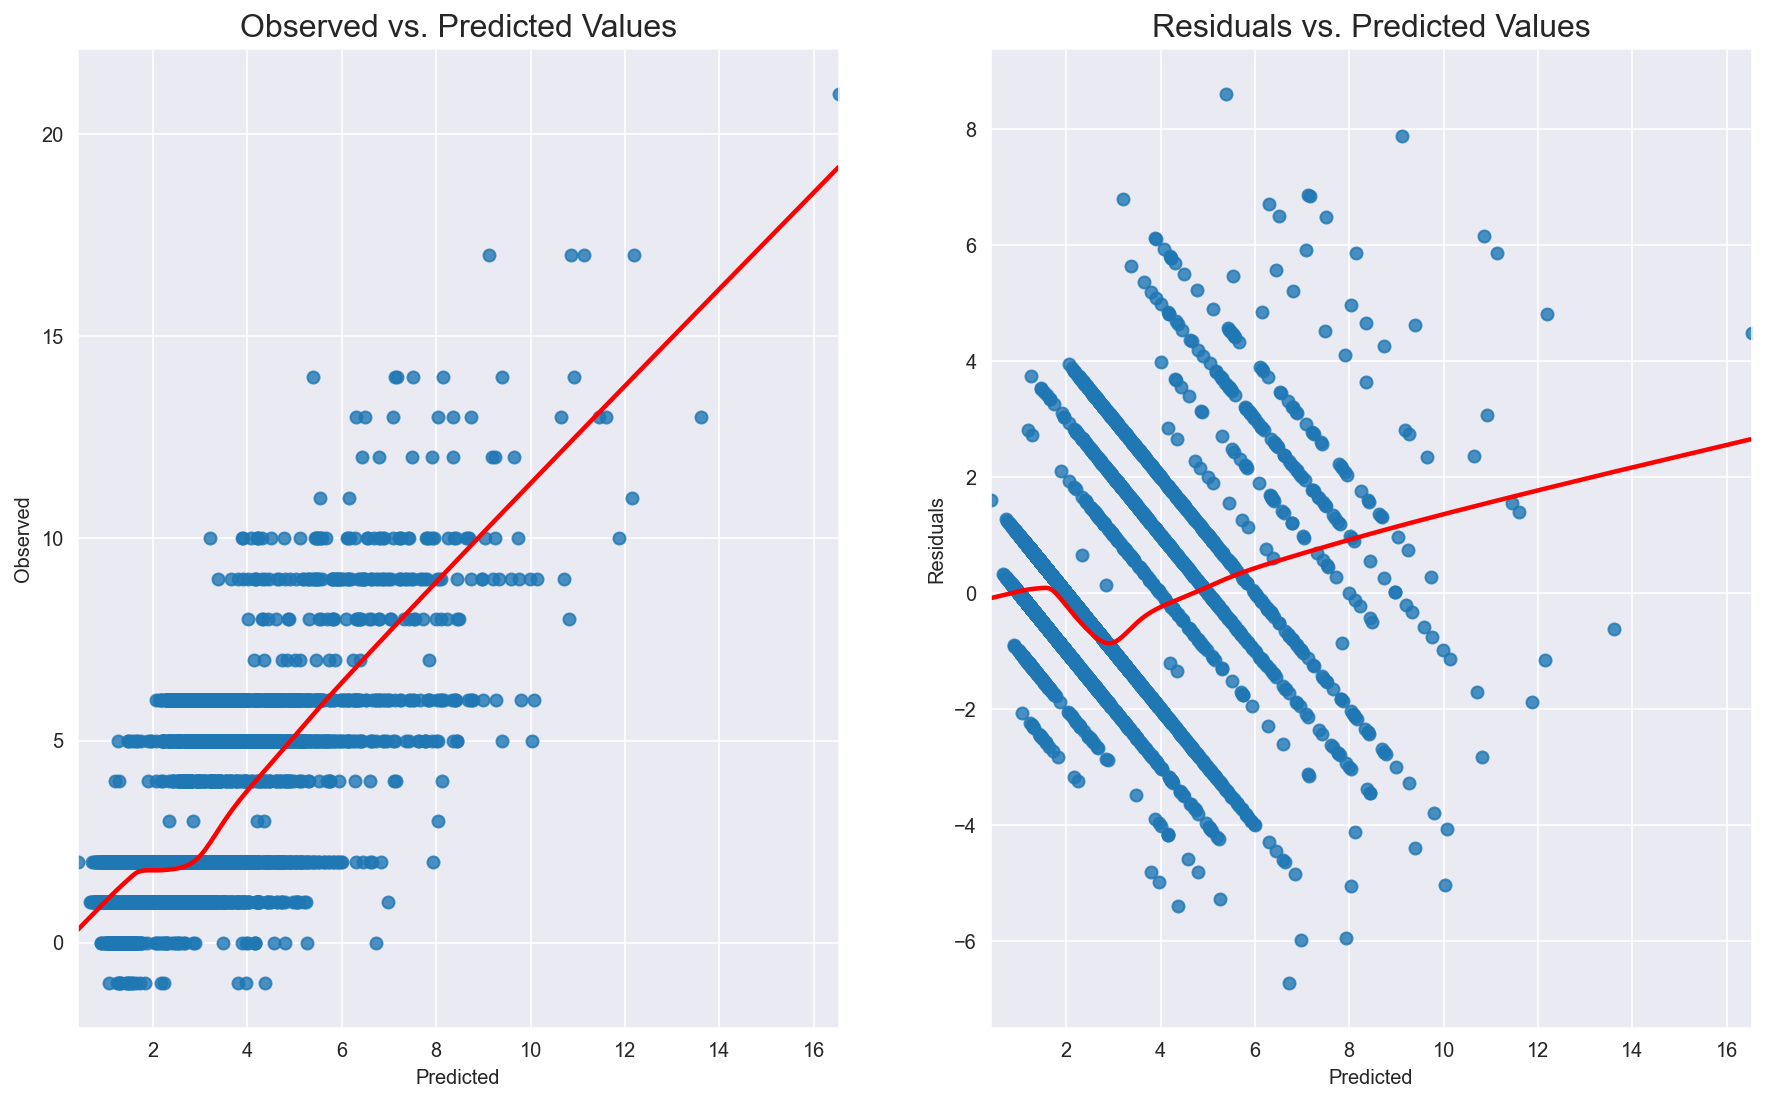

In [29]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2)
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')
    
linearity_test(lin_reg_new, y_new)    


 Breusch-Pagan test ----
                                     value
Lagrange multiplier statistic  2815.254855
p-value                           0.000000
f-value                         232.673087
f p-value                         0.000000

 Goldfeld-Quandt test ----
                value
F statistic  1.001212
p-value      0.483195

 Residuals plots ----


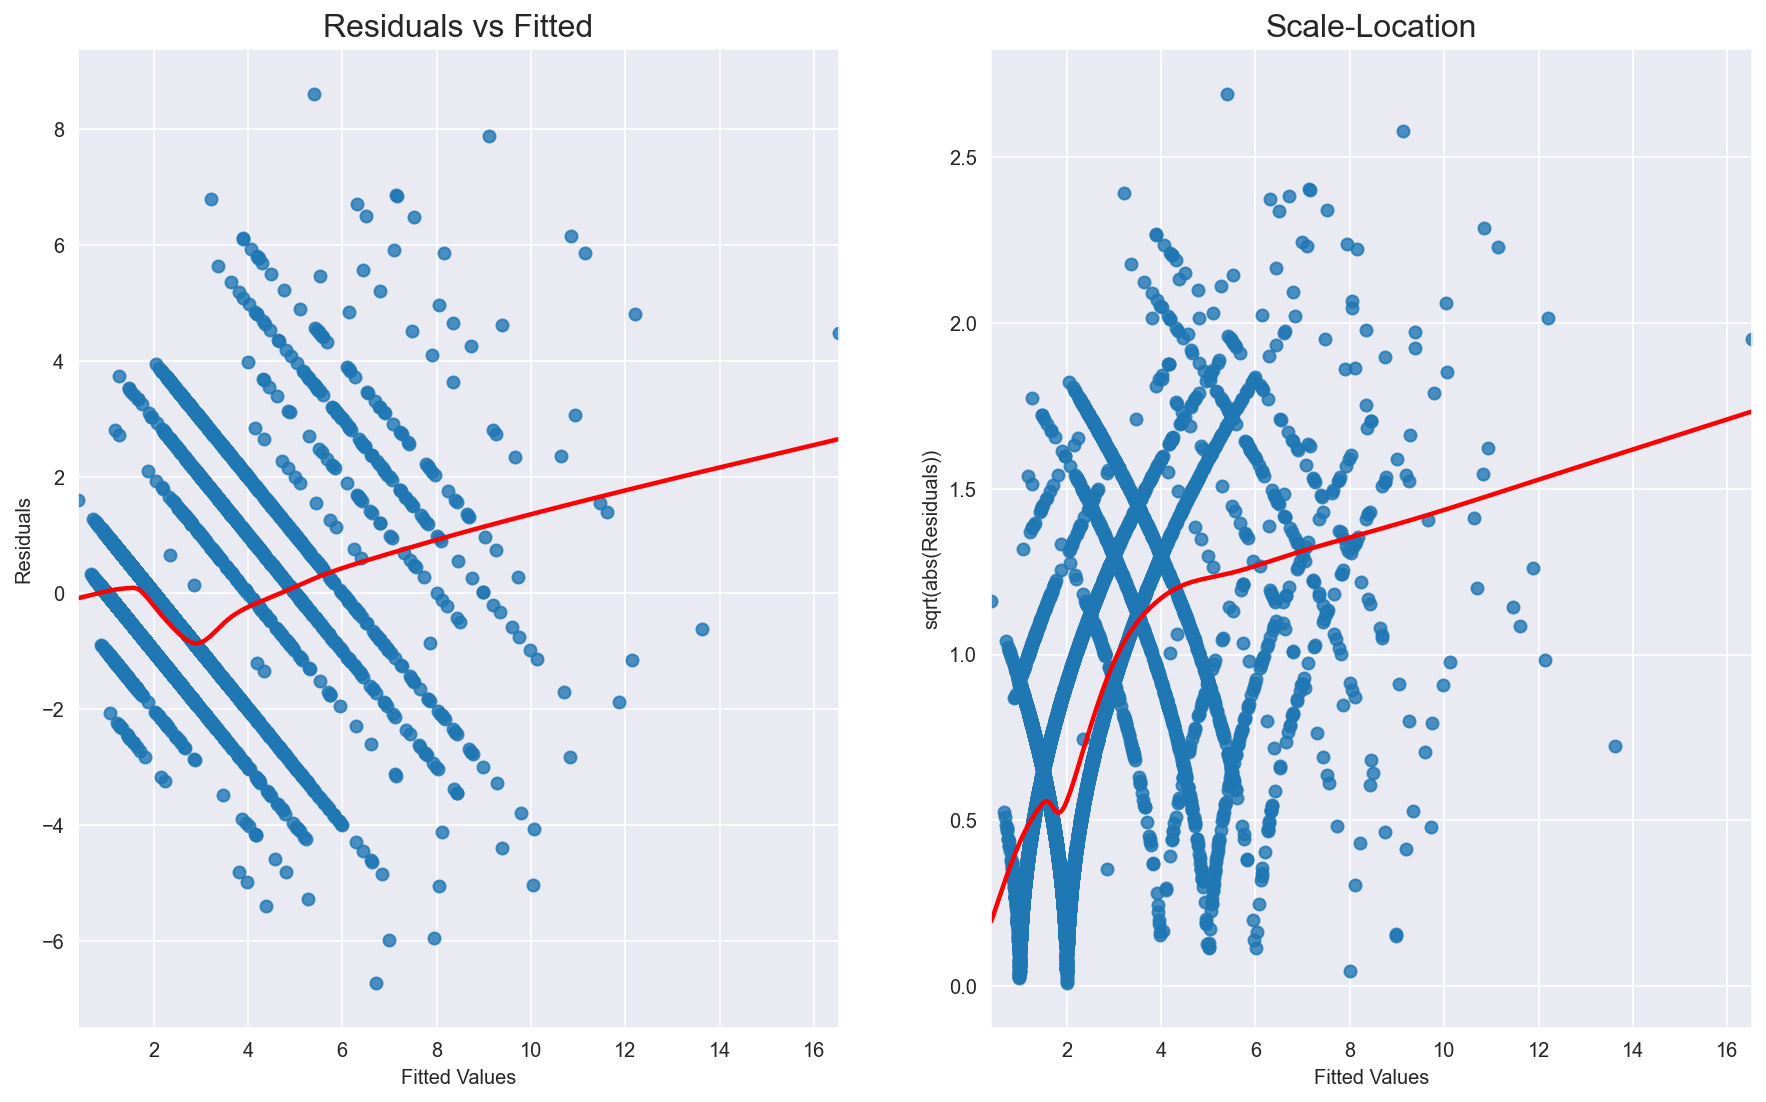

In [30]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

def homoscedasticity_test(model):
    '''
    Function for testing the homoscedasticity of residuals in a linear regression model.
    It plots residuals and standardized residuals vs. fitted values and runs Breusch-Pagan and Goldfeld-Quandt tests.
    
    Args:
    * model - fitted OLS model from statsmodels
    '''
    fitted_vals = model.predict()
    resids = model.resid
    resids_standardized = model.get_influence().resid_studentized_internal

    fig, ax = plt.subplots(1,2)

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuals vs Fitted', fontsize=16)
    ax[0].set(xlabel='Fitted Values', ylabel='Residuals')

    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Scale-Location', fontsize=16)
    ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')

    bp_test = pd.DataFrame(sms.het_breuschpagan(resids, model.model.exog), 
                           columns=['value'],
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

    gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, model.model.exog)[:-1],
                           columns=['value'],
                           index=['F statistic', 'p-value'])

    print('\n Breusch-Pagan test ----')
    print(bp_test)
    print('\n Goldfeld-Quandt test ----')
    print(gq_test)
    print('\n Residuals plots ----')

homoscedasticity_test(lin_reg_new)

/Users/yashwant/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Jarque-Bera test ---- statistic: 7591.2095, p-value: 0.0
Shapiro-Wilk test ---- statistic: 0.9236, p-value: 0.0000
Kolmogorov-Smirnov test ---- statistic: 0.0942, p-value: 0.0000
Anderson-Darling test ---- statistic: 224.7999, 5% critical value: 0.7870
If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. 


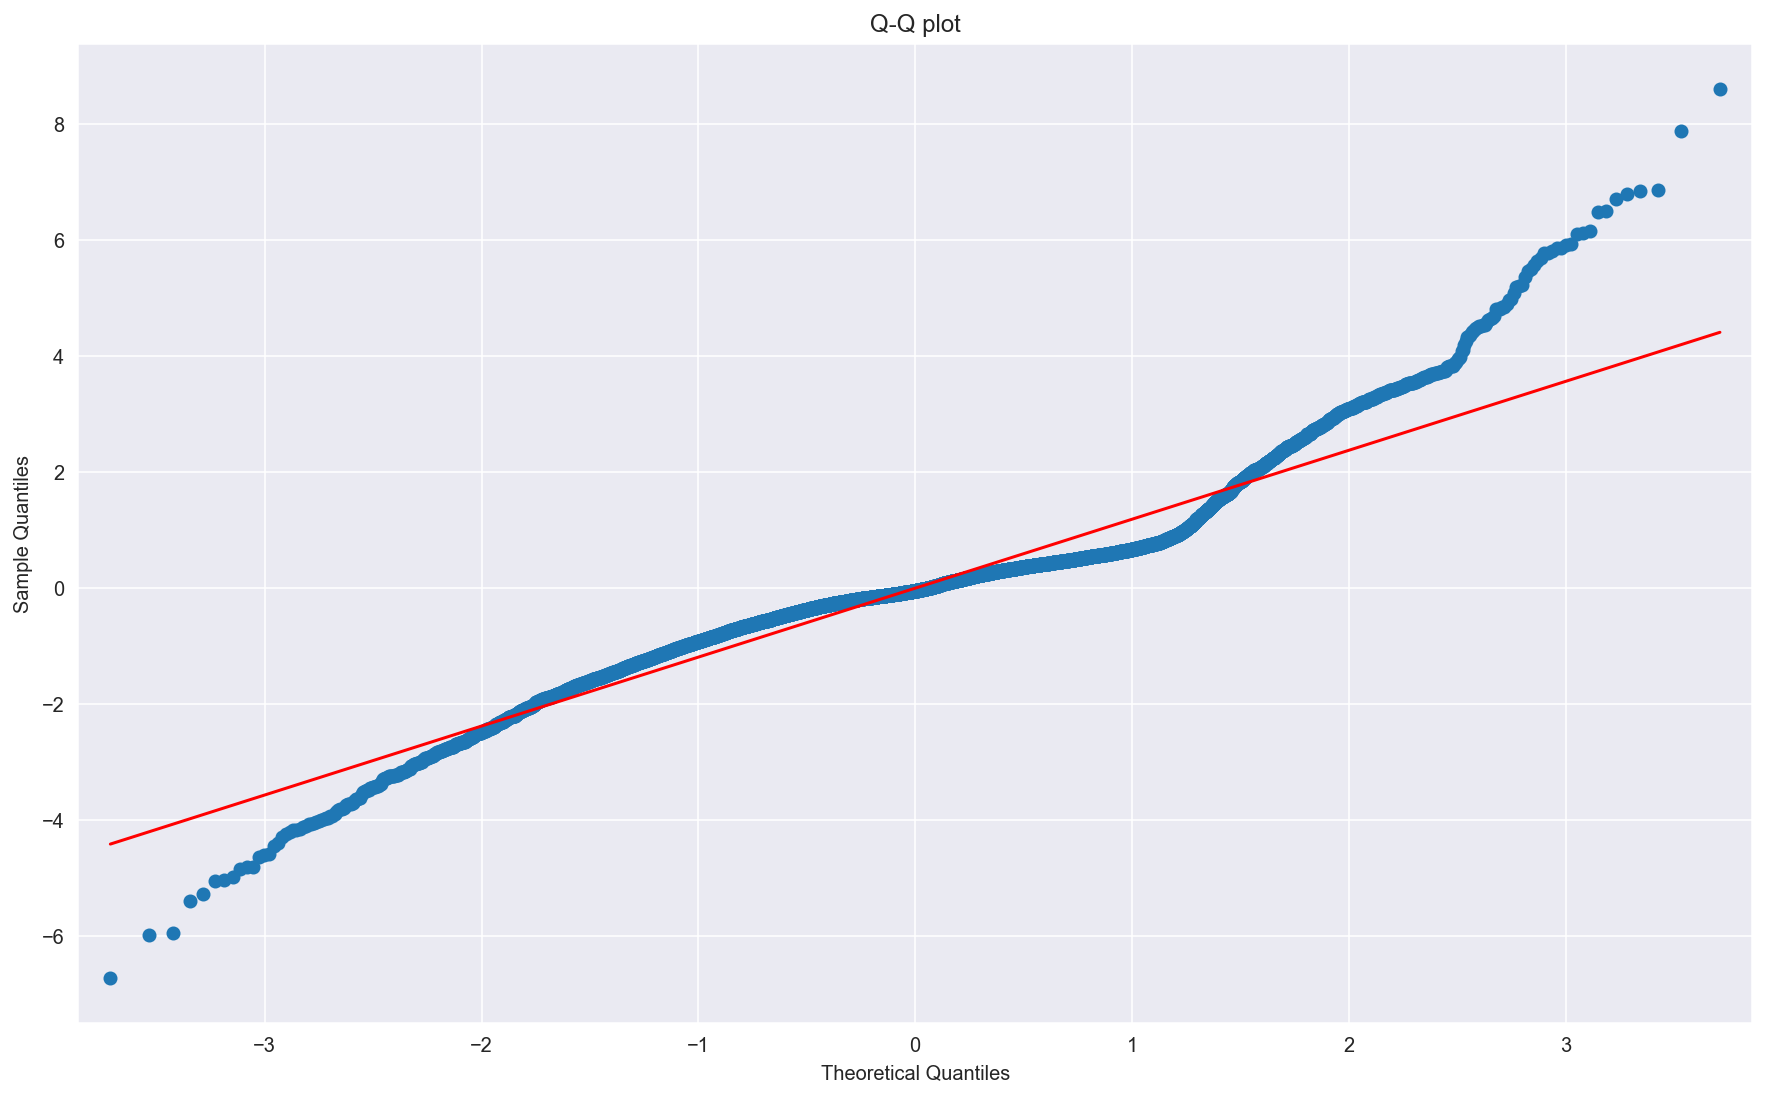

In [31]:

def normality_of_residuals_test(model):
    '''
    Function for drawing the normal QQ-plot of the residuals and running 4 statistical tests to 
    investigate the normality of residuals.
    
    Arg:
    * model - fitted OLS models from statsmodels
    '''
    sm.ProbPlot(model.resid).qqplot(line='s');
    plt.title('Q-Q plot');

    jb = stats.jarque_bera(model.resid)
    sw = stats.shapiro(model.resid)
    ad = stats.anderson(model.resid, dist='norm')
    ks = stats.kstest(model.resid, 'norm')
    
    print(f'Jarque-Bera test ---- statistic: {jb[0]:.4f}, p-value: {jb[1]}')
    print(f'Shapiro-Wilk test ---- statistic: {sw[0]:.4f}, p-value: {sw[1]:.4f}')
    print(f'Kolmogorov-Smirnov test ---- statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}')
    print(f'Anderson-Darling test ---- statistic: {ad.statistic:.4f}, 5% critical value: {ad.critical_values[2]:.4f}')
    print('If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. ')
    
normality_of_residuals_test(lin_reg_new)

The plots (residuals vs fitted, QQ-plot, etc) above suggest violations of the linear regression assumptions. Predictions from this model might not be reliable.

## XGBoost

In [32]:

X = df_model_nogk.loc[:,~df_model_nogk.columns.isin(['fpl_position','fpl_points','Venue','rank','name'])]
y = df_model_nogk['fpl_points']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state = 1)


In [33]:
regressor = xgb.XGBRegressor(
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=3
)

regressor.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [34]:
y_pred = regressor.predict(X_test)
mean_squared_error(y_test, y_pred)


1.4432733124744712

In [35]:
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 57.74%


In [36]:
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)
params = {'eval_metric':'logloss',
          'eta':0.01,
          'subsample':0.1}
xgb_cv = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, metrics = 'logloss',seed=1) 
xgb_cv

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.517279,0.007207,0.523350,0.009524
1,0.339854,0.011677,0.349723,0.016280
2,0.161168,0.018673,0.176818,0.027024
3,-0.017259,0.026926,0.002957,0.033685
4,-0.213498,0.032478,-0.185524,0.052755
5,-0.415630,0.033686,-0.383628,0.069728
6,-0.871778,0.208634,-0.726494,0.246693
7,-1.910127,0.370908,-1.767785,0.691275
8,-3.535532,0.683858,-2.943093,0.978468
9,-5.290067,0.937691,-5.131395,1.223975


In [37]:
#hyperparameter tuning XGB
grid = pd.DataFrame({'eta':[0.01,0.05,0.1]*2,
'subsample':np.repeat([0.1,0.3],3)})
def fit(x):
    params = {
              'eval_metric':'logloss',
              'eta':x[0],
              'subsample':x[1]}
    xgb_cv = xgb.cv(dtrain=data_dmatrix, params=params, 
    nfold=5, metrics = 'logloss',seed=42)
    return xgb_cv[-1:].values[0]

grid[['train-logloss-mean','train-logloss-std',
'test-logloss-mean','test-logloss-std']] = grid.apply(fit,axis=1,result_type='expand')
grid

,eta,subsample,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.01,0.1,-4.737693,0.522172,-4.429735,0.795526
1,0.05,0.1,-42.997763,1.127699,-42.543938,0.927524
2,0.10,0.1,-47.191510,0.289675,-47.051575,1.124152
3,0.01,0.3,-6.930057,0.709778,-5.662827,0.719903
4,0.05,0.3,-43.810991,0.378836,-43.474958,1.256501
5,0.10,0.3,-47.342821,0.345426,-47.155610,1.117838


In [38]:
xgb_reg = xgb.XGBRegressor(
                           eval_metric = 'logloss',
                           eta = 0.1,
                           subsample = 0.3)

xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric='logloss', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0, ...)

In [39]:
y_pred_cv = xgb_reg.predict(X_test)
predictions = [round(value) for value in y_pred_cv]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 58.92%


In [40]:
#saving the model to use later for ML based appx
import pickle
pickle_out = open("xgb.pkl","wb")
pickle.dump(xgb_reg,pickle_out)
pickle_out.close()

We observe that the hypertuned XG model performs the best and much better than the linear regression models. This is expected as XGBoost can handle non-linear and correlated data much more efficiently as compared to linear regression.